In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import calendar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving city_day.csv to city_day.csv


In [ ]:
# Load data
df = pd.read_csv("city_day.csv")

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# List of pollutants
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx',
              'NH3', 'CO', 'SO2', 'O3', 'Benzene',
              'Toluene', 'Xylene']

# Fill pollutant missing values with median
df[pollutants] = df[pollutants].fillna(df[pollutants].median())

# Drop rows with missing AQI or AQI_Bucket
df.dropna(subset=['AQI', 'AQI_Bucket'], inplace=True)

In [ ]:
# Extract time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['Month_Name'] = df['Month'].apply(lambda x: calendar.month_abbr[x])

# Encode AQI bucket
le = LabelEncoder()
df['AQI_Label'] = le.fit_transform(df['AQI_Bucket'])

# Preview
df.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,...,Xylene,AQI,AQI_Bucket,Year,Month,Day,Weekday,WeekOfYear,Month_Name,AQI_Label
28,Ahmedabad,2015-01-29,83.13,95.68,6.93,28.71,33.72,15.85,6.93,49.52,...,3.14,209.0,Poor,2015,1,29,3,5,Jan,2
29,Ahmedabad,2015-01-30,79.84,95.68,13.85,28.68,41.08,15.85,13.85,48.49,...,4.81,328.0,Very Poor,2015,1,30,4,5,Jan,5
30,Ahmedabad,2015-01-31,94.52,95.68,24.39,32.66,52.61,15.85,24.39,67.39,...,7.67,514.0,Severe,2015,1,31,5,5,Jan,4
31,Ahmedabad,2015-02-01,135.99,95.68,43.48,42.08,84.57,15.85,43.48,75.23,...,25.87,782.0,Severe,2015,2,1,6,5,Feb,4
32,Ahmedabad,2015-02-02,178.33,95.68,54.56,35.31,72.80,15.85,54.56,55.04,...,35.61,914.0,Severe,2015,2,2,0,6,Feb,4


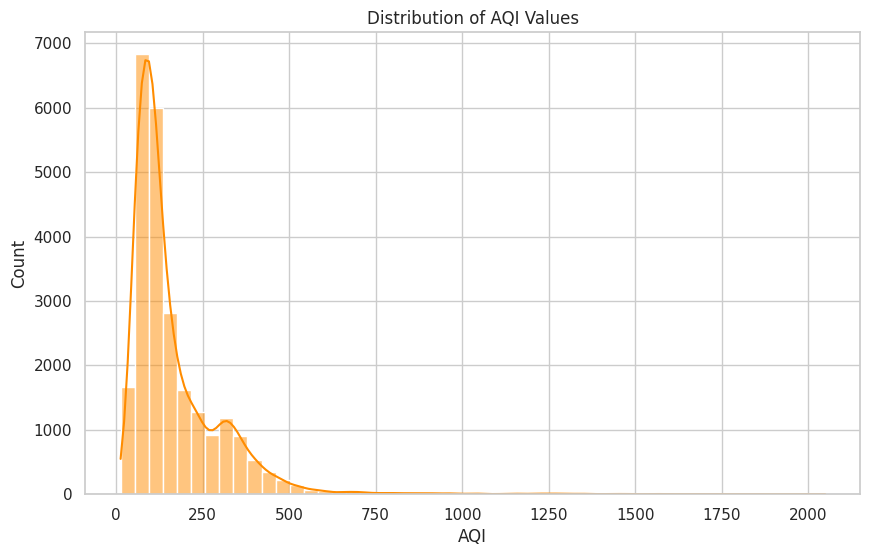

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(df['AQI'], kde=True, bins=50, color='darkorange') #kernel density estimate - smoothens out histogram to give idea of the distribution
plt.title("Distribution of AQI Values")
plt.xlabel("AQI")
plt.ylabel("Count")
plt.show()

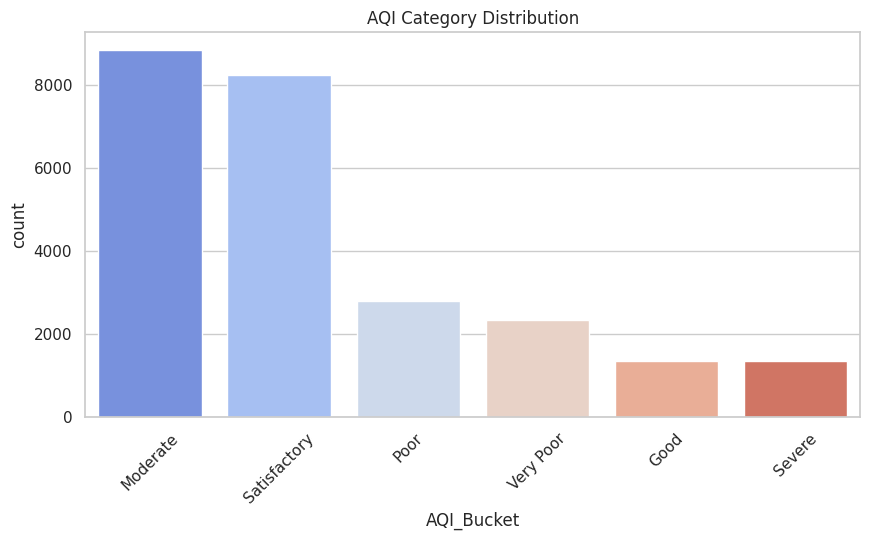

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='AQI_Bucket', data=df, order=df['AQI_Bucket'].value_counts().index, palette='coolwarm')
#automatically counts the freq of each bucket
plt.title("AQI Category Distribution")
plt.xticks(rotation=45)
plt.show()

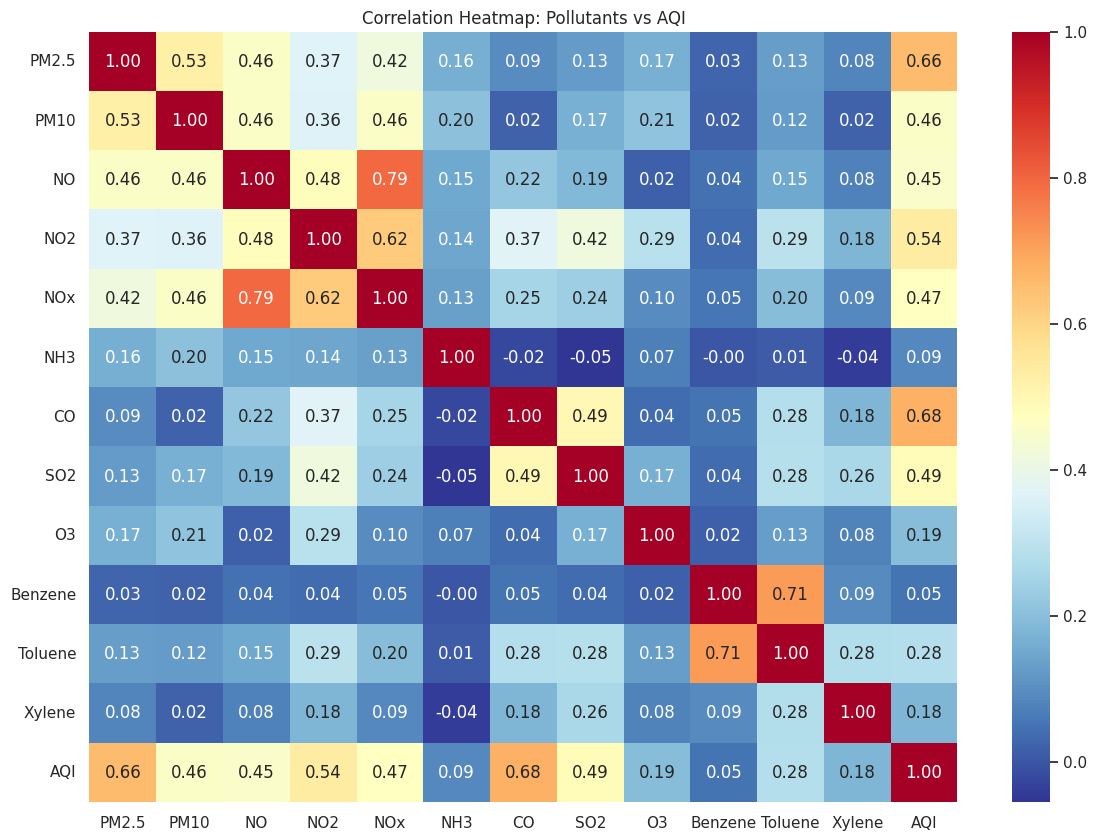

In [ ]:
plt.figure(figsize=(14,10))
sns.heatmap(df[pollutants + ['AQI']].corr(), annot=True, fmt=".2f", cmap='RdYlBu_r') #to get correlation matrix, see how strong the relationship is between the columns
plt.title("Correlation Heatmap: Pollutants vs AQI")
plt.show()

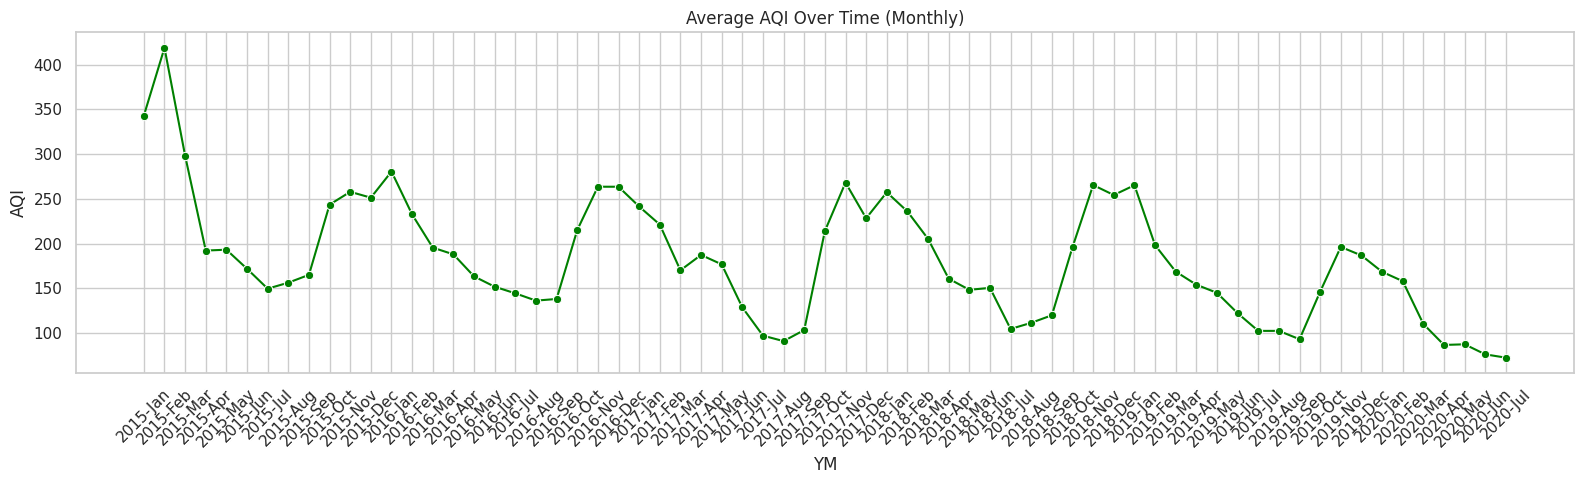

In [ ]:
monthly_avg = df.groupby(['Year', 'Month'])['AQI'].mean().reset_index()
monthly_avg['Month_Name'] = monthly_avg['Month'].apply(lambda x: calendar.month_abbr[x])
monthly_avg['YM'] = monthly_avg['Year'].astype(str) + '-' + monthly_avg['Month_Name']

plt.figure(figsize=(16, 5))
sns.lineplot(x='YM', y='AQI', data=monthly_avg, marker='o', color='green')
plt.xticks(rotation=45)
plt.title("Average AQI Over Time (Monthly)")
plt.ylabel("AQI")
plt.tight_layout()
plt.show()

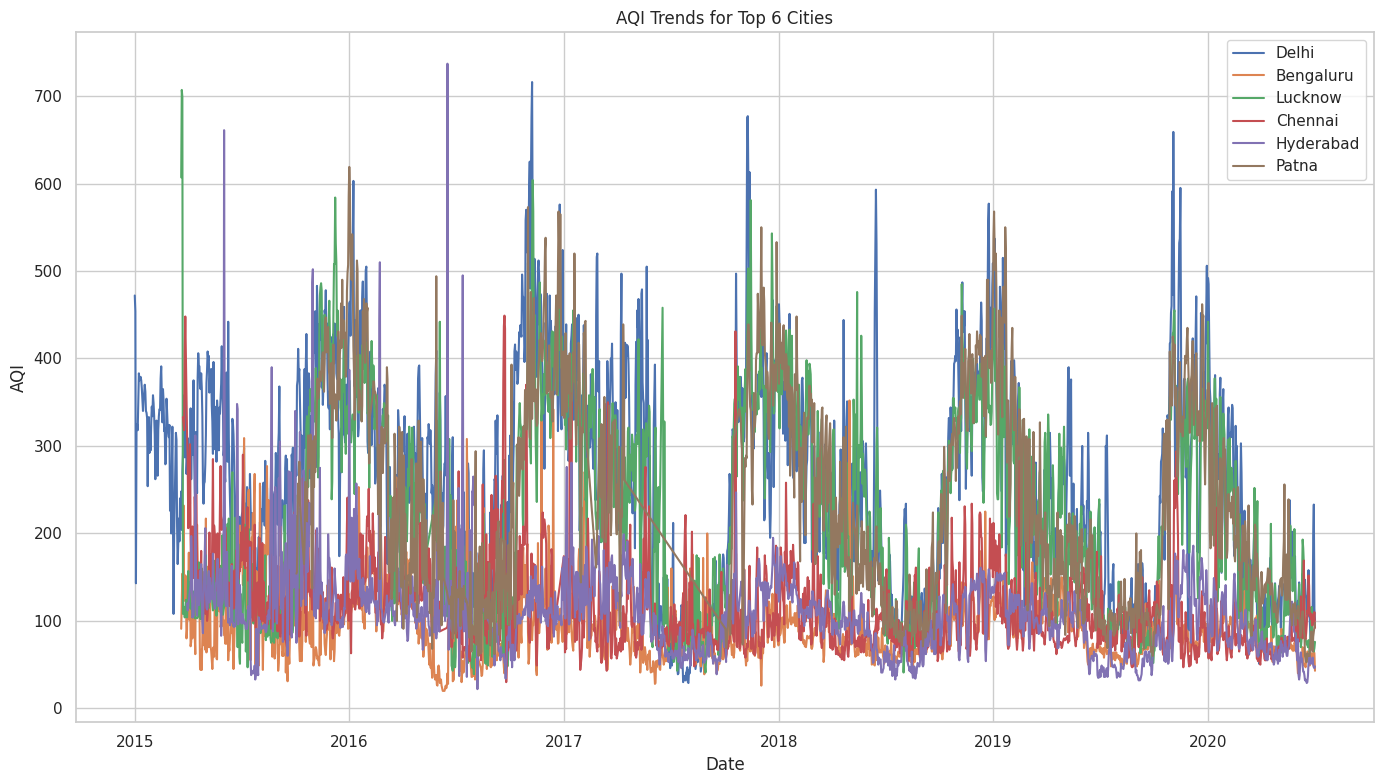

In [ ]:
top_cities = df['City'].value_counts().nlargest(6).index
plt.figure(figsize=(14,8))

for city in top_cities:
    subset = df[df['City'] == city].groupby('Date')['AQI'].mean().reset_index()
    plt.plot(subset['Date'], subset['AQI'], label=city)

plt.title("AQI Trends for Top 6 Cities")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

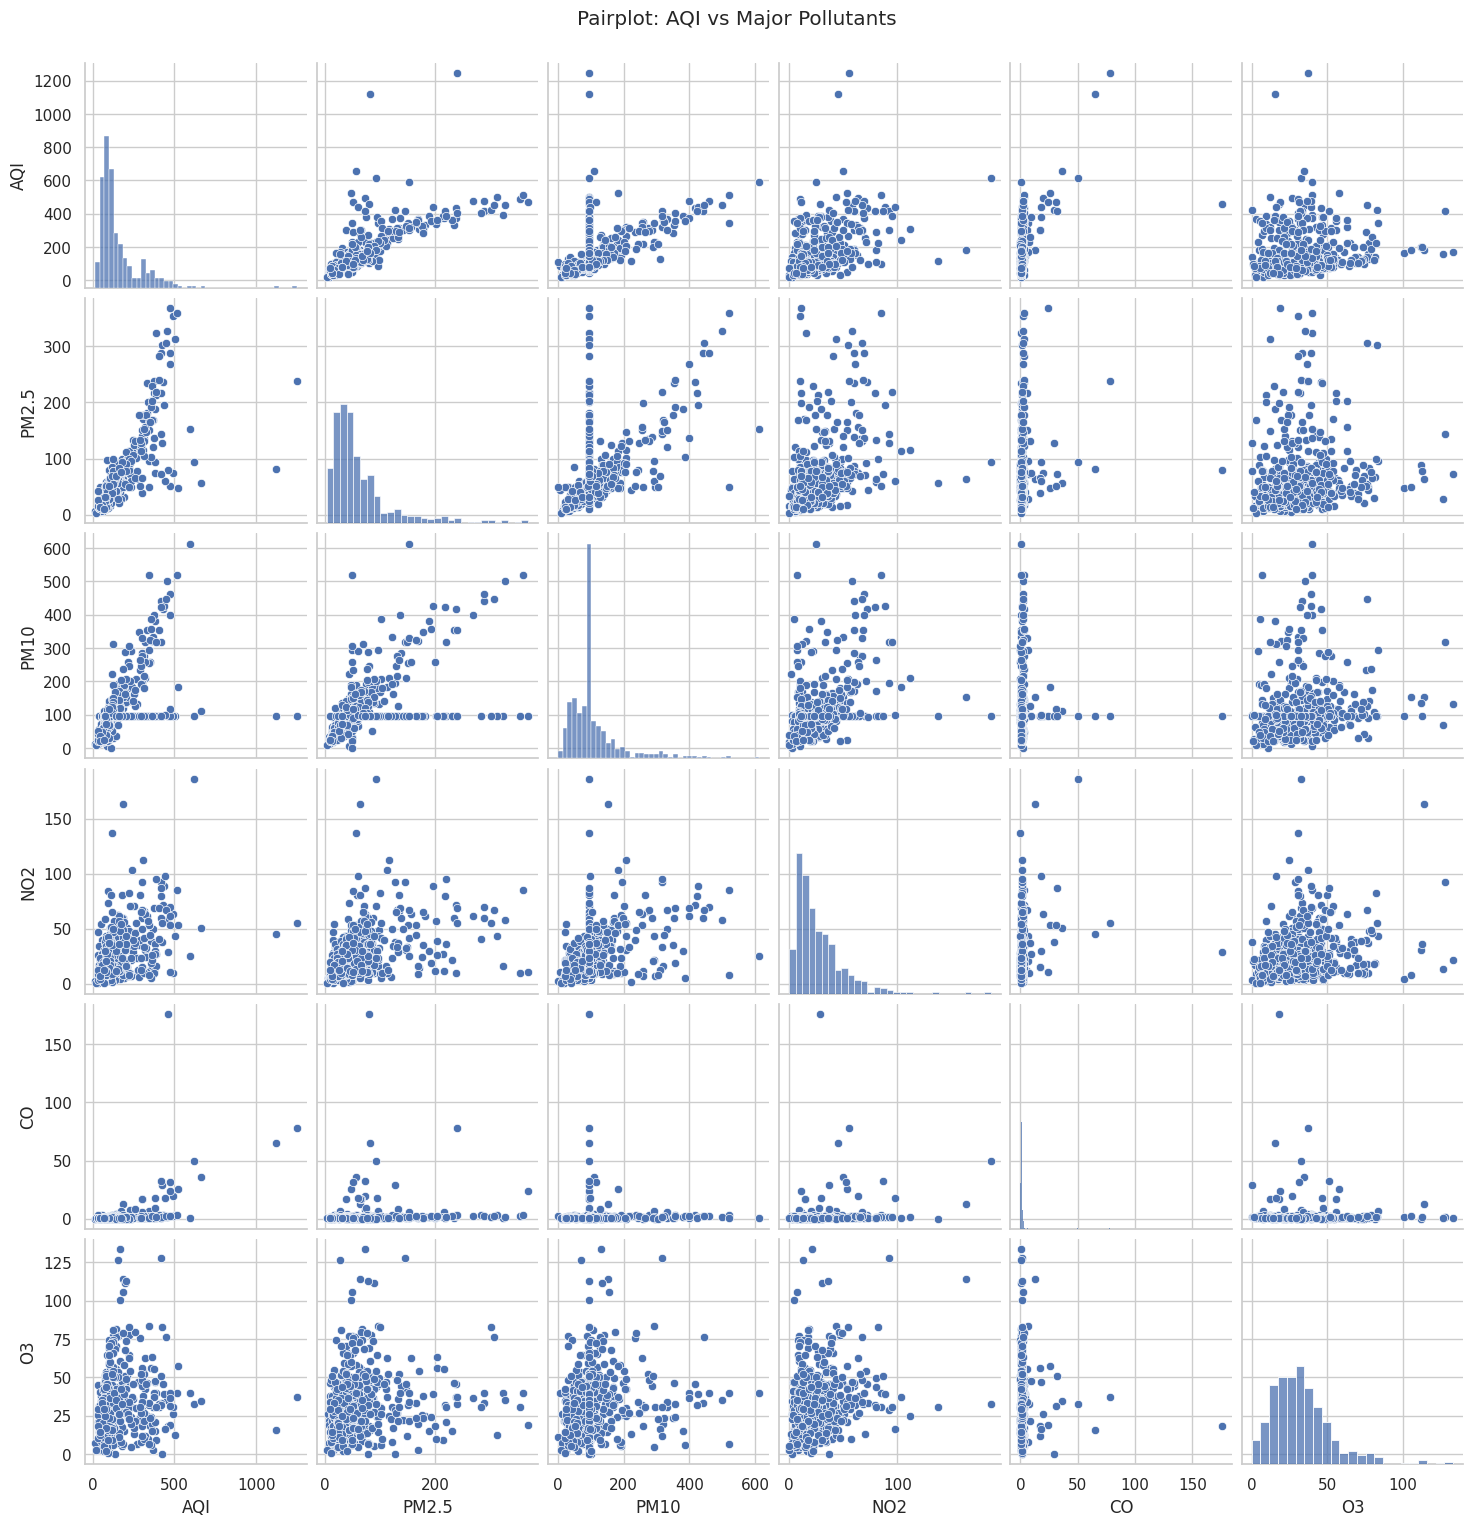

In [ ]:
sample = df[['AQI', 'PM2.5', 'PM10', 'NO2', 'CO', 'O3']].sample(500)
sns.pairplot(sample)
plt.suptitle("Pairplot: AQI vs Major Pollutants", y=1.02)
plt.show()

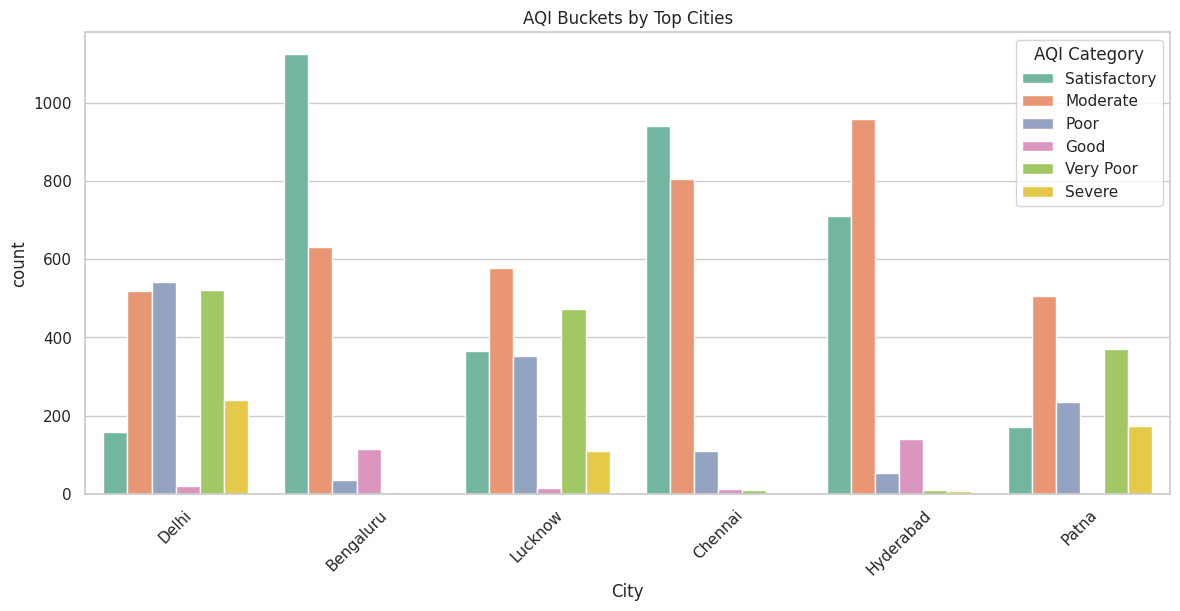

In [ ]:
plt.figure(figsize=(14,6))
sns.countplot(data=df[df['City'].isin(top_cities)],
              x='City', hue='AQI_Bucket',
              order=top_cities, palette='Set2')
plt.title("AQI Buckets by Top Cities")
plt.xticks(rotation=45)
plt.legend(title="AQI Category")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features
features = pollutants + ['Year', 'Month', 'Day', 'Weekday']
X = df[features]
y_reg = df['AQI']              # Regression Target
y_clf = df['AQI_Label']        # Classification Target

# Train-test split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

regressors = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    "XGBoost": XGBRegressor(objective="reg:squarederror", verbosity=0)
}

print("Regression Results:\n")
for name, model in regressors.items():
    model.fit(X_train_reg_scaled, y_train_reg)
    preds = model.predict(X_test_reg_scaled)
    mae = mean_absolute_error(y_test_reg, preds)
    rmse = np.sqrt(mean_squared_error(y_test_reg, preds))
    r2 = r2_score(y_test_reg, preds)

    print(f" {name}")
    print(f" MAE:  {mae:.2f}")
    print(f" RMSE: {rmse:.2f}")
    print(f" R²:   {r2:.4f}")
    print("-" * 50)

Regression Results:

 Linear Regression
 MAE:  31.00
 RMSE: 59.27
 R²:   0.8082
--------------------------------------------------
 Decision Tree
 MAE:  28.73
 RMSE: 56.97
 R²:   0.8227
--------------------------------------------------
 Random Forest
 MAE:  20.65
 RMSE: 40.61
 R²:   0.9099
--------------------------------------------------
 Gradient Boosting
 MAE:  23.67
 RMSE: 43.31
 R²:   0.8976
--------------------------------------------------
 AdaBoost
 MAE:  146.77
 RMSE: 158.30
 R²:   -0.3685
--------------------------------------------------
 XGBoost
 MAE:  21.59
 RMSE: 42.37
 R²:   0.9019
--------------------------------------------------


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "Neural Network": MLPClassifier(max_iter=500),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

print(" Classification Results:\n")
for name, model in classifiers.items():
    model.fit(X_train_clf_scaled, y_train_clf)
    preds = model.predict(X_test_clf_scaled)
    acc = accuracy_score(y_test_clf, preds)
    print(f" {name}")
    print(f" Accuracy: {acc:.4f}")
    print(classification_report(y_test_clf, preds, target_names=le.classes_))
    print("Confusion Matrix:\n", confusion_matrix(y_test_clf, preds))
    print("-" * 50)

 Classification Results:

 Logistic Regression
 Accuracy: 0.7503
              precision    recall  f1-score   support

        Good       0.76      0.32      0.45       282
    Moderate       0.75      0.82      0.78      1745
        Poor       0.64      0.54      0.58       555
Satisfactory       0.77      0.83      0.80      1655
      Severe       0.84      0.72      0.78       271
   Very Poor       0.74      0.72      0.73       462

    accuracy                           0.75      4970
   macro avg       0.75      0.66      0.69      4970
weighted avg       0.75      0.75      0.74      4970

Confusion Matrix:
 [[  91    4    0  187    0    0]
 [   2 1430   75  230    1    7]
 [   0  200  298    3    2   52]
 [  27  244    1 1381    0    2]
 [   0    6   15    0  195   55]
 [   0   15   79    0   34  334]]
--------------------------------------------------
 Decision Tree
 Accuracy: 0.7288
              precision    recall  f1-score   support

        Good       0.63      0.62  

In [ ]:
# Voting Classifier Ensemble
voting_clf = VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
], voting='hard')

voting_clf.fit(X_train_clf_scaled, y_train_clf)
voting_preds = voting_clf.predict(X_test_clf_scaled)

print(" Voting Classifier:")
print(f"Accuracy: {accuracy_score(y_test_clf, voting_preds):.4f}")
print(classification_report(y_test_clf, voting_preds, target_names=le.classes_))

 Voting Classifier:
Accuracy: 0.8121
              precision    recall  f1-score   support

        Good       0.88      0.65      0.74       282
    Moderate       0.81      0.86      0.84      1745
        Poor       0.68      0.65      0.67       555
Satisfactory       0.85      0.87      0.86      1655
      Severe       0.86      0.79      0.82       271
   Very Poor       0.77      0.74      0.76       462

    accuracy                           0.81      4970
   macro avg       0.81      0.76      0.78      4970
weighted avg       0.81      0.81      0.81      4970



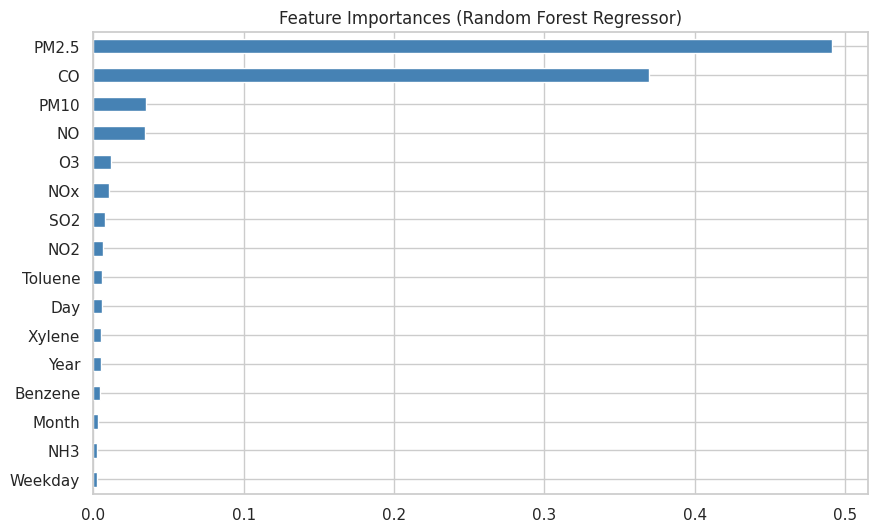

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_reg, y_train_reg)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

plt.figure(figsize=(10,6))
importances.plot(kind='barh', color='steelblue')
plt.title("Feature Importances (Random Forest Regressor)")
plt.show()

<Figure size 800x600 with 0 Axes>

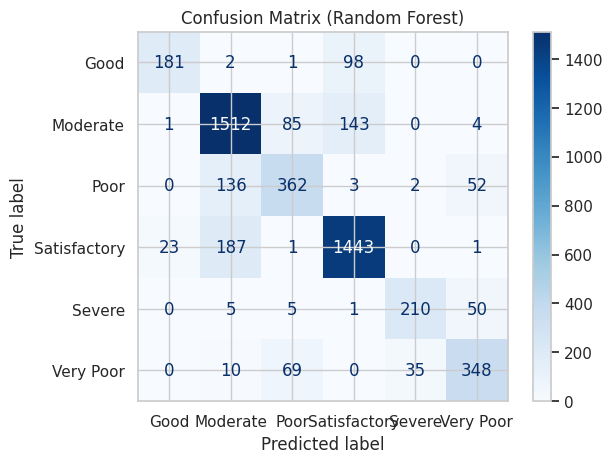

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

model = RandomForestClassifier()
model.fit(X_train_clf_scaled, y_train_clf)
preds = model.predict(X_test_clf_scaled)

cm = confusion_matrix(y_test_clf, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Random Forest)")
plt.show()

In [26]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=5,
    cv=3,                # 3-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1            # Use all available CPU cores
)

# Fit the model
random_search.fit(X_train_clf_scaled, y_train_clf)

# Output best parameters and score
print("Best Parameters from RandomizedSearch:")
print(random_search.best_params_)
print(f"Accuracy: {random_search.best_score_:.4f}")

Best Parameters from GridSearch:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.8084


In [ ]:
#TIME SERIES

In [25]:
import pandas as pd

# Load your dataset
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(['City', 'Date'], inplace=True)

# Group by City and Date for daily AQI
city_aqi = df.groupby(['City', 'Date'])['AQI'].mean().reset_index()

# Display example
city_aqi.head()

,City,Date,AQI
0,Ahmedabad,2015-01-29,209.0
1,Ahmedabad,2015-01-30,328.0
2,Ahmedabad,2015-01-31,514.0
3,Ahmedabad,2015-02-01,782.0
4,Ahmedabad,2015-02-02,914.0


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7uzf87tc/u9meg5lk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7uzf87tc/_k2age0s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32679', 'data', 'file=/tmp/tmp7uzf87tc/u9meg5lk.json', 'init=/tmp/tmp7uzf87tc/_k2age0s.json', 'output', 'file=/tmp/tmp7uzf87tc/prophet_model38ba82v4/prophet_model-20250414100753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:07:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:07:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


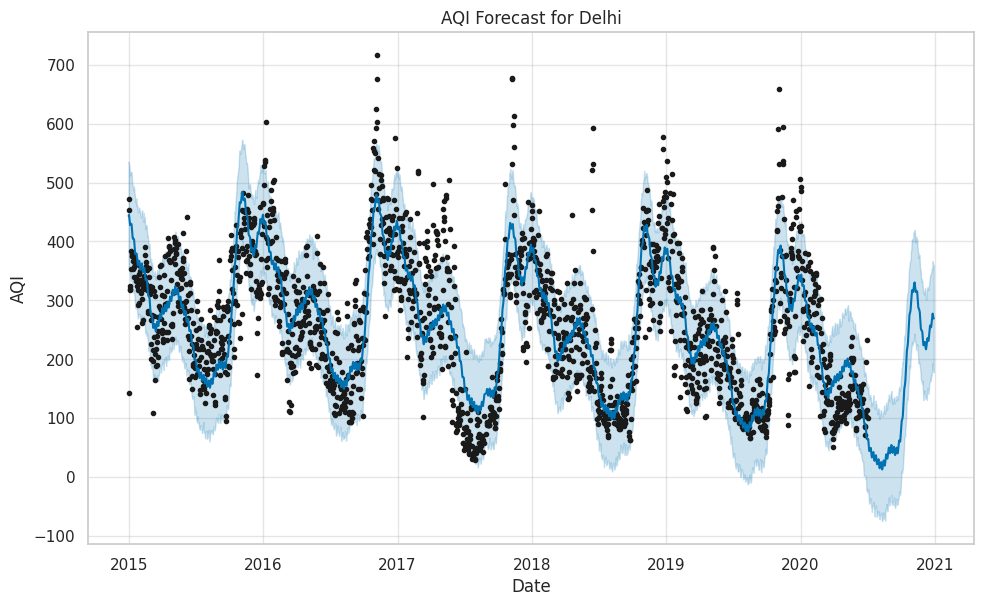

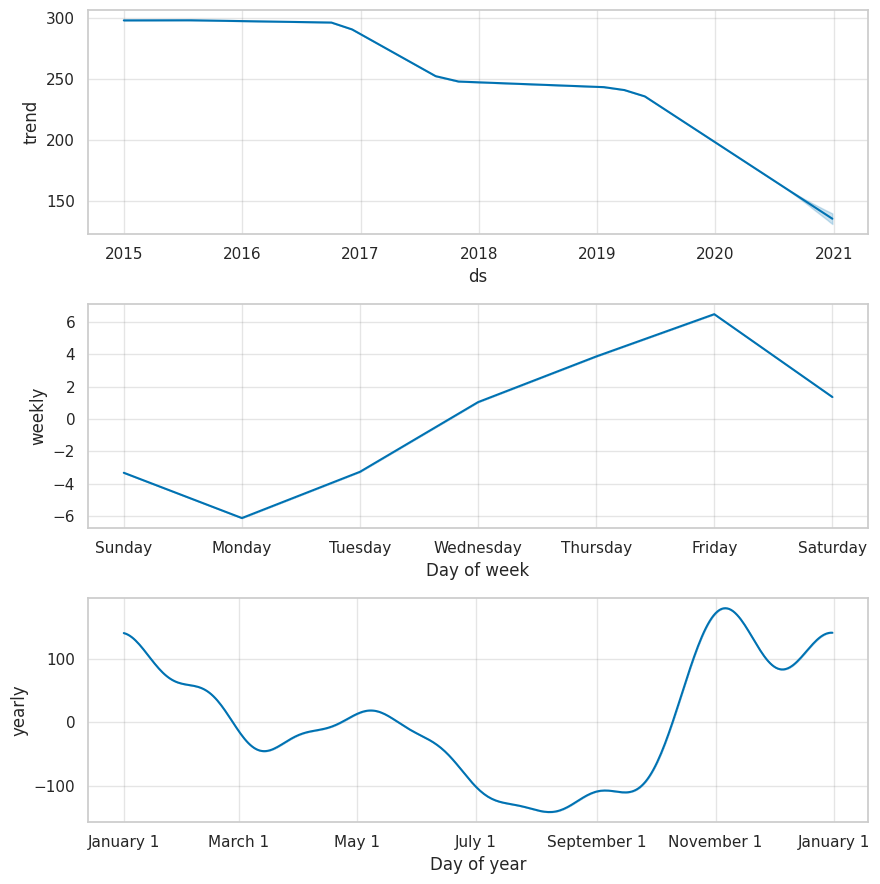

In [ ]:
from prophet import Prophet
import matplotlib.pyplot as plt

def forecast_city(city_name, periods=180):
    city_df = city_aqi[city_aqi['City'] == city_name][['Date', 'AQI']].dropna()
    city_df.columns = ['ds', 'y']  # Prophet expects these column names

    model = Prophet()
    model.fit(city_df)

    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f"AQI Forecast for {city_name}")
    plt.xlabel("Date")
    plt.ylabel("AQI")
    plt.show()

    # Plot components (trend, seasonality)
    model.plot_components(forecast)
    plt.show()

#Example
forecast_city("Delhi")

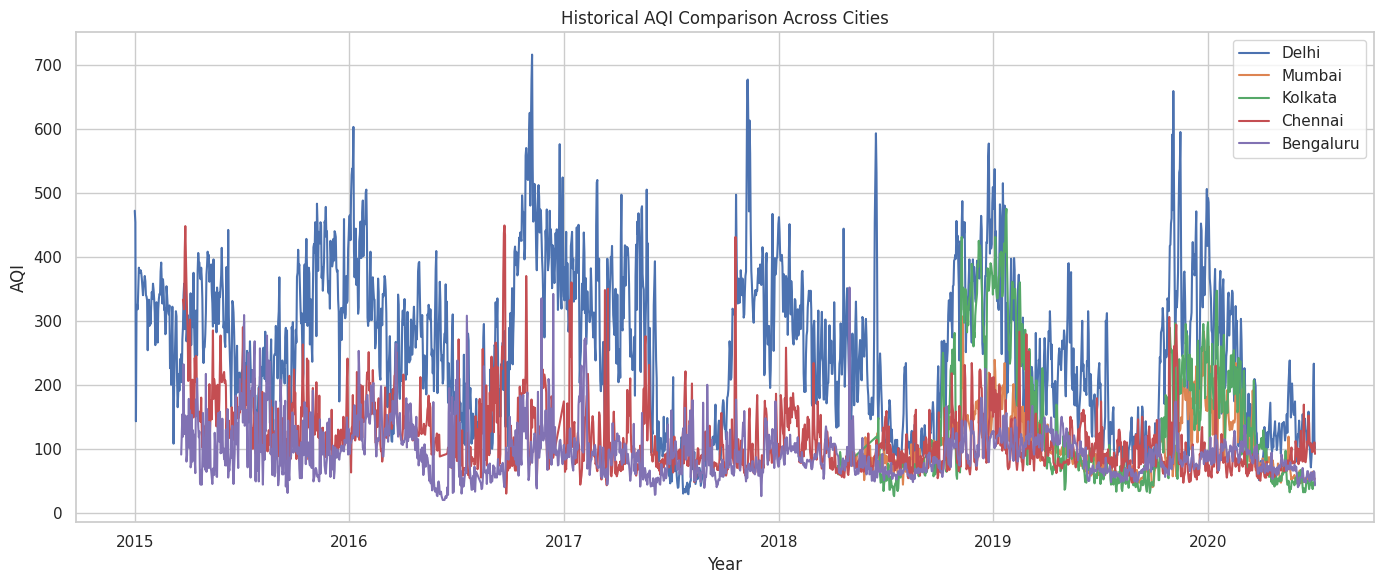

In [ ]:
import seaborn as sns

plt.figure(figsize=(14,6))
sample_cities = ['Delhi', 'Mumbai', 'Kolkata', 'Chennai', 'Bengaluru']
for city in sample_cities:
    subset = city_aqi[city_aqi['City'] == city]
    plt.plot(subset['Date'], subset['AQI'], label=city)

plt.title("Historical AQI Comparison Across Cities")
plt.xlabel("Year")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


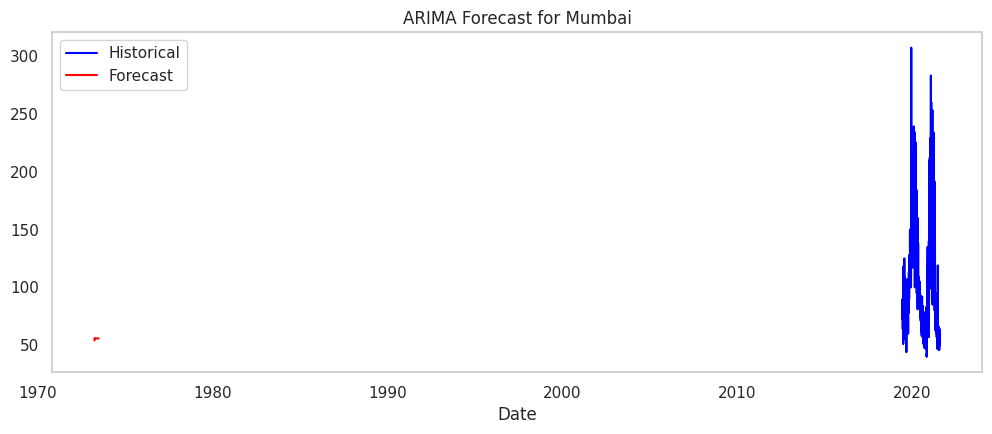

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(city_name, steps=90):
    city_df = city_aqi[city_aqi['City'] == city_name].set_index('Date')['AQI'].dropna()

    model = ARIMA(city_df, order=(2,1,2))  # You can auto-tune this with pmdarima
    fitted = model.fit()

    forecast = fitted.forecast(steps=steps)

    plt.figure(figsize=(12,5))
    city_df.plot(label='Historical', color='blue')
    forecast.plot(label='Forecast', color='red')
    plt.title(f"ARIMA Forecast for {city_name}")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage
arima_forecast("Mumbai")

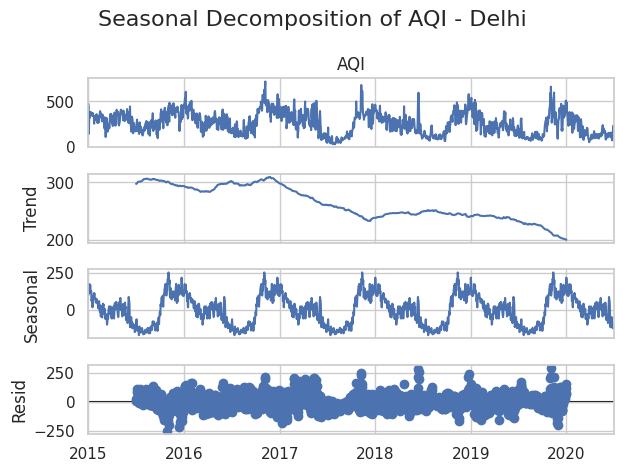

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_city(city_name):
    city_df = city_aqi[city_aqi['City'] == city_name].set_index('Date')['AQI'].dropna()
    result = seasonal_decompose(city_df, model='additive', period=365)

    result.plot()
    plt.suptitle(f"Seasonal Decomposition of AQI - {city_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# Try
decompose_city("Delhi")